## Fitting

Fitting CARMA models to time series data using __EzTao__ can be done in just one line. We demonstrate how to quickly get reliable best-fit CARMA parameters using the built-in fitting functions. However, you are not bound to the built-in functions; you can use the CARMA kernels to compute the likelihood and combine that with other optimizers to get the best-fit parameters, which we will also demonstrate.

### The built-in fitting functions

There are three built-in fitting functions included in the [eztao.ts.carma_fit](../python/ts.rst#module-eztao.ts.carma_fit) module:

- `drw_fit`: Fit a DRW model to the input time series
- `dho_fit`: Fit a DHO/CARMA(2,1) model to the input time series
- `carma_fit`: Fit an arbitrary CARMA model (must specify p and q order) to the input time series.

The first two should be used if you want to fit either DRW or DHO to the data, and the last one can be used to fit any CARMA models.  Next, let's take a closer look at the `carma_fit` function. We will start by simulating a CARMA process and fit using `carma_fit`, then compare the best-fit parameters to the ones used in simulation.

In [1]:
import numpy as np
from eztao.carma import DHO_term
from eztao.ts import gpSimRand
from eztao.ts import carma_fit

# define a DHO kernel
dho_kernel = DHO_term(np.log(0.04), np.log(0.0027941), np.log(0.004672), 
                      np.log(0.0257))

# simulate a DHO process
SNR = 10
duration = 365*10.0
npts = 200
t, y, yerr = gpSimRand(dho_kernel, SNR, duration, npts)

In [2]:
%%time
# fit
p = 2
q = 1
best_fit = carma_fit(t, y, yerr, p, q, n_opt=10)

print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {best_fit}')
print('----------------------------------------------------')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.03026792 0.00316738 0.0043432  0.02235601]
----------------------------------------------------
CPU times: user 1e+03 ms, sys: 0 ns, total: 1e+03 ms
Wall time: 998 ms


From the cell above, we can see that it took ~ 1 second (if not shorter) to obtain a best-fit that is quite close to the input. The robust performance is a result of a combination of many carefully chosen fitting components, most importantly, the $\mathit{celerite}$ backend for fast evaluation of the likelihood function and a powerful global optimizer for efficient exploration of the parameter space. However, we want to note that to better fit time series to models that are more complex than CARMA(2,1), more robust global optimizer might be needed. In the last section, we will show how to use your own optimizer to obtain best-fit parameters. 

<div class="alert alert-info">

Note

The built-in fitting functions use a modified version of the general purpose `scipy.optimize.minimize` optimizer with the 'L-BFGS-B' method. The modification is simply running the optimizing algorithm many more times and each time with a different initialization, as a result, the possibility of getting stuck in a local minimum is significantly reduce. That said, it is still possible to get stuck in a local minimum. Two apparent solutions are: increasing the number of times to run the optimizer through setting the `n_iter` argument or using a more robust optimizer. 

</div>

#### Fit CARMA models that are more complex than CARMA(2,1)

<div class="alert alert-warning">

Warning

The regular CARMA parameter space (specified by the defining stochastic differential equation, see [Introduction](00_About_CARMA.ipynb#Introduction) for a reference) is no longer continuous (meaning giving a stationary process) when p > 2! Read the text below for more details.

</div>

More care must be taken when fitting CARMA models that are more complex than CARMA(2,1). The reason is that the vanilla CARMA parameter space is no longer continuous when p > 2; in other words, a random set of CARMA parameters may not produce a stable CARMA process, thus cannot return a valid likelihood during the fitting process. The solution to this problem is to sample from a space spanned by the coefficients of the AR/MA characteristic polynomials in the factored form. To learn more about this property of CARMA, please check out the papers linked in [Introduction](./00_Introduction.ipynb).

With __EzTao__, you don't need to worry about the transformation between these two spaces. `carma_fit` will automatically fit in the polynomial space when the p order is greater than 2 and return the best-fit parameters in the regular CARMA space.

In [3]:
from eztao.carma import CARMA_term

# simulate a CARMA(3,0) process
carma_kernel = CARMA_term(np.log([3, 3.189, 0.05]), np.log([0.5]))

SNR = 50
duration = 365*10.0
npts = 1000
t2, y2, yerr2 = gpSimRand(carma_kernel, SNR, duration, npts, log_flux=False)

Text(0.5, 1.0, 'Simulated CARMA(3,0) process')

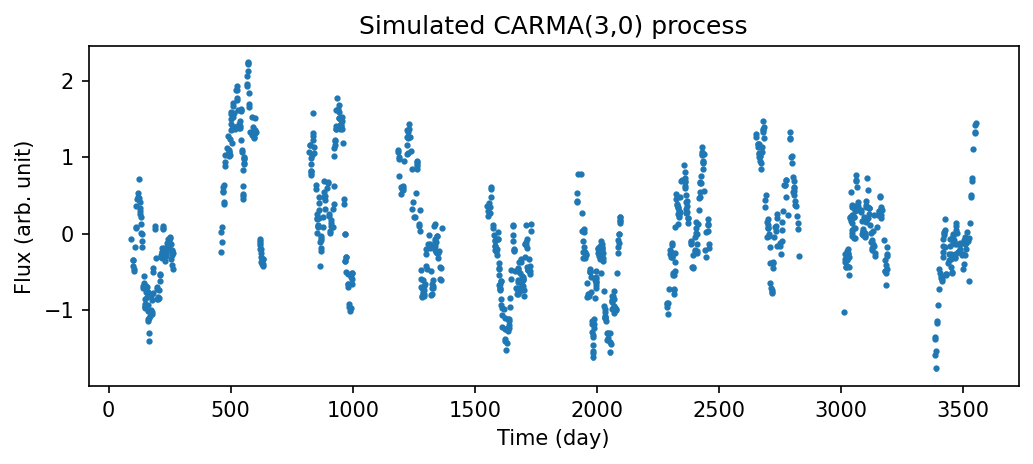

In [4]:
import matplotlib.pyplot as plt

# plot the simulated process
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8,3))
ax.errorbar(t2, y2, yerr2, fmt='.', markersize=4)
ax.set_xlabel('Time (day)')
ax.set_ylabel('Flux (arb. unit)')
ax.set_title('Simulated CARMA(3,0) process')

Now, let's fit a CARMA(3,0) model to the time series we just simulated.

In [5]:
best_fit2 = carma_fit(t2, y2, yerr2, 3, 0, n_opt=20)
print(f'True input CARMA(3,0) parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit CARMA(3,0) parameters: {best_fit2}')
print('----------------------------------------------------')

True input CARMA(3,0) parameters:[3.    3.189 0.05  0.5  ]
Best-fit CARMA(3,0) parameters: [3.2138727  3.5245589  0.08045436 0.56983312]
----------------------------------------------------


<div class='alert alert-info'>

Note

We stress that getting accurate/reliable best-fit parameters for CARMA processes that are more complex than CARMA(2,1) might require more robust optimizers than what's currently implemented. Our experience also tells us that the higher the order of the CARMA model that we are fitting the higher the SNR of the input time series is needed in order to obtain accurate/reliable best-fits.

</div>

### Use your own optimizer
Using your own optimizer is very straight forward. All you need to do is use your optimizer to generate parameter proposals and use the CARMA kernels from __EzTao__ to compose a likelihood function. Caution should be taken when you fit higher-order models (p > 2) for the reasons that I explained [above](#Fitting-CARMA-models-that-are-more-complex-than-CARMA(2,1)), and we will reemphasize this below. We will use the steps shown in $\mathit{celerite}$'s [online tutorials](https://celerite.readthedocs.io/en/stable/tutorials/first/) to illustrate this process. 

#### Fit models that are equally or less complex than CARMA(2,1)
The process to fit those three models (DRW, CARMA(2,0) and DHO) is no different than what's shown in $\mathit{celerite}$'s tutorials. You can compose your own likelihood function, ``neg_log_like``, like what's being demonstrated; __EzTao__ also provides a likelihood function---``neg_param_ll``, where ``ll`` stands for log likelihood.

In [6]:
from celerite import GP
from eztao.ts import neg_param_ll
from eztao.ts import sample_carma
from scipy.optimize import minimize

Initialize kernel and GP model

In [7]:
# randomly generate some DHO parameters and use it to define a DHO kernel/GP
dho_ar, dho_ma = sample_carma(2, 1)
dho_kernel_fit = CARMA_term(np.log(dho_ar), np.log(dho_ma))
gp = GP(dho_kernel_fit, mean=np.median(y))
gp.compute(t, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -12242.923471469716


Search for the best-fit parameters by minimizing the negative log likelihood

In [8]:
# optimize to find DHO parameters giving the highest log likelihood (lowest negative log likelihood)
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_param_ll, initial_params, bounds=bounds, method="L-BFGS-B", args=(y, gp))
gp.set_parameter_vector(r.x)

In [9]:
print(f'True input DHO parameters:{np.exp(dho_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(r.x)}')
print(f'Final log likelihood: {gp.log_likelihood(y)}')

True input DHO parameters:[0.04      0.0027941 0.004672  0.0257   ]
Best-fit DHO parameters: [0.03026764 0.0031674  0.00434319 0.02235577]
Final log likelihood: 155.98060793657382


#### Fit models that are more complex than CARMA(2,1)
Fitting higher-order models to a time series needs to use `neg_foceff_ll` instead of `neg_param_ll`. If you would like to compose your own likelihood function, you should use `gp.kernel.set_log_fcoeffs(params)` instead of `gp.set_parameter_vector(params)` for updating the parameters of the CARMA kernel. The current implementation doesn't allow combining CARMA kernels with other kernels (e.g., jitter or a trend), but future versions, especially after switching the backend to $\mathit{celerite2}$, will support this feature.

Initialize kernel and GP model

In [10]:
from eztao.ts import carma_log_fcoeff_init, neg_fcoeff_ll, sample_carma

# drawing in the polynomial space
init_log_fcoeff = carma_log_fcoeff_init(3, 0)

# convert to CARMA space
init_log_ar, init_log_ma = CARMA_term.fcoeffs2carma_log(init_log_fcoeff, 3)

# initialize kernel, GP
carma_kernel_fit = CARMA_term(init_log_ar, init_log_ma)
gp2 = GP(carma_kernel_fit, mean=np.median(y2))
gp2.compute(t2, yerr2)
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y2)))

Initial log likelihood: -1022276.573386126


Search for the best-fit parameters by minimizing the negative log likelihood

In [11]:
# give it a 'valid' boundary
ARbounds = [(-8, 8)] * 3
MAbounds = [(-5, 5)] * (0 + 1)
bounds = ARbounds + MAbounds

initial_params = carma_log_fcoeff_init(3, 0)
r2 = minimize(neg_fcoeff_ll, initial_params, bounds=bounds, method="L-BFGS-B", 
              args=(y2, gp2))
gp2.kernel.set_log_fcoeffs(r2.x)

In [12]:
print(f'True input DHO parameters:{np.exp(carma_kernel.get_parameter_vector())}')
print(f'Best-fit DHO parameters: {np.exp(gp2.get_parameter_vector())}')
print(f'Final log likelihood: {gp2.log_likelihood(y2)}')

True input DHO parameters:[3.    3.189 0.05  0.5  ]
Best-fit DHO parameters: [4.37649810e-02 1.18011723e+03 1.31578235e+01 1.11481870e+02]
Final log likelihood: 585.1020341593951


<div class="alert alert-info">

A Note on Fitting
    
- We can only do as good as the likelihood landscape allows (given you are not providing a useful prior landscape). 
- The quality of the likelihood landscape (regarding smoothness and the ability to recover true parameters) depends on the properties of the input time series, such as temporal sampling and the level of measurement noise relative the RMS amplitude of the underlying CARMA process.
    
</div>